In [11]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [12]:
import sys
sys.executable

'/Users/tudorl/Documents/workspace/personal/dtreeviz/venv/bin/python'

In [15]:
import sys
import os
# add library module to PYTHONPATH
sys.path.append(f"{os.getcwd()}/../")

import sklearn
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import xgboost as xgb
from xgboost import plot_importance, plot_tree, plotting

from dtreeviz import trees 
from dtreeviz import treeviz

import graphviz
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import pandas as pd
import numpy as np
from dtreeviz.models.shadow_decision_tree import ShadowDecTree3
from dtreeviz.models.xgb_decision_tree import XGBDTree
from dtreeviz import treeviz
from dtreeviz import exceptions

In [17]:
treeviz.add(1,2)

3

In [18]:
pd.options.display.max_rows = 999

# Train

In [25]:
random_state = 1234
dataset = pd.read_csv("../data/titanic/titanic.csv")
# Fill missing values for Age
dataset.fillna({"Age":dataset.Age.mean()}, inplace=True)
# Encode categorical variables
dataset["Sex_label"] = dataset.Sex.astype("category").cat.codes
dataset["Cabin_label"] = dataset.Cabin.astype("category").cat.codes
dataset["Embarked_label"] = dataset.Embarked.astype("category").cat.codes
features = ["Pclass", "Age", "Fare", "Sex_label", "Cabin_label", "Embarked_label"]
target = "Survived"

In [26]:
dtrain = xgb.DMatrix(dataset[features], dataset[target])

In [69]:
params = {"max_depth":6, "eta":0.05, "objective":"binary:logistic", "subsample":1}
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=8)

In [70]:
xgb_model.trees_to_dataframe().query("Tree == 0")

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,Sex_label,1.000000,0-1,0-2,0-1,246.604279,222.75
1,0,1,0-1,Pclass,3.000000,0-3,0-4,0-3,60.127525,78.50
2,0,2,0-2,Cabin_label,4.000000,0-5,0-6,0-5,29.516968,144.25
3,0,3,0-3,Leaf,NaN,NaN,NaN,NaN,0.087356,42.50
4,0,4,0-4,Fare,23.350000,0-7,0-8,0-7,17.870434,36.00
5,0,5,0-5,Age,3.500000,0-9,0-10,0-9,14.429703,118.25
6,0,6,0-6,Age,17.500000,0-11,0-12,0-11,8.358520,26.00
7,0,7,0-7,Embarked_label,2.000000,0-13,0-14,0-13,4.715125,29.25
8,0,8,0-8,Leaf,NaN,NaN,NaN,NaN,-0.067742,6.75
9,0,9,0-9,Fare,20.825001,0-15,0-16,0-15,3.044444,3.50


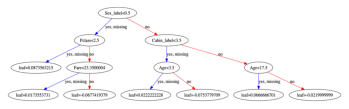

In [29]:
# rcParams['figure.figsize'] = 50,30
plot_tree(xgb_model)

# save the model

In [30]:
import joblib
# joblib.dump(xgb_model, "xgb_model")

# Init shadow tree

In [71]:
from dtreeviz.models.xgb_decision_tree import XGBDTree


In [72]:
d = dataset[features+ [target]].iloc[:800]
d_matrix = xgb.DMatrix(d)

In [73]:
xgb_shadow = XGBDTree(xgb_model, 1, d[features], d[target], features, target, class_names=[0, 1])

# Parameters meaning
- cover https://stackoverflow.com/questions/33520460/how-is-xgboost-cover-calculated
- https://rdrr.io/cran/xgboost/man/xgb.model.dt.tree.html
- https://eli5.readthedocs.io/en/latest/tutorials/index.html

## left, right children

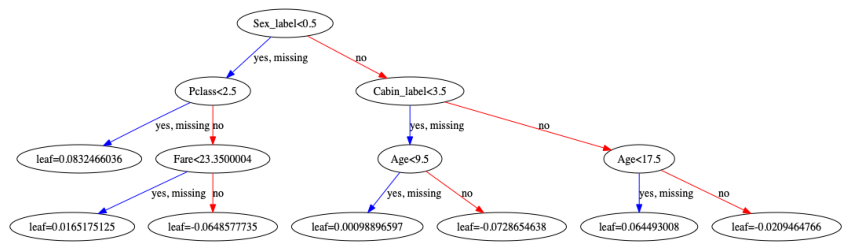

In [35]:
rcParams['figure.figsize'] = 15,10
plot_tree(xgb_model, num_trees=1)

In [21]:
[node.id for node in xgb_shadow.internal]

[1, 2, 0]

In [22]:
[node.id for node in xgb_shadow.leaves]

[3, 4, 5, 6]

## Node split/threshold

In [23]:
??plot_tree

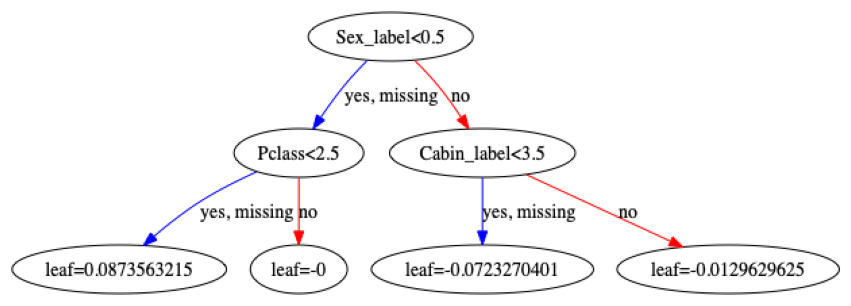

In [24]:
rcParams['figure.figsize'] = 15,10
plot_tree(xgb_model, num_trees=0)

In [26]:
#??xgb_model.get_dump

In [30]:
xgb_model.get_dump(dump_format="text")[1]

'0:[Sex_label<1] yes=1,no=2,missing=1\n\t1:[Pclass<3] yes=3,no=4,missing=3\n\t\t3:leaf=0.0832466036\n\t\t4:leaf=-0\n\t2:[Cabin_label<4] yes=5,no=6,missing=5\n\t\t5:leaf=-0.0688317642\n\t\t6:leaf=-0.0123393293\n'

In [60]:
xgb_model.get_dump(dump_format="json")[1]

'  { "nodeid": 0, "depth": 0, "split": "Sex_label", "split_condition": 1, "yes": 1, "no": 2, "missing": 1 , "children": [\n    { "nodeid": 1, "depth": 1, "split": "Pclass", "split_condition": 3, "yes": 3, "no": 4, "missing": 3 , "children": [\n      { "nodeid": 3, "leaf": 0.0832466036 }, \n      { "nodeid": 4, "leaf": -0 }\n    ]}, \n    { "nodeid": 2, "depth": 1, "split": "Cabin_label", "split_condition": 4, "yes": 5, "no": 6, "missing": 5 , "children": [\n      { "nodeid": 5, "leaf": -0.0688317642 }, \n      { "nodeid": 6, "leaf": -0.0123393293 }\n    ]}\n  ]}'

In [27]:
xgb_model.get_dump(dump_format="dot")[1]

'digraph {\n    graph [ rankdir=TB ]\n\n    0 [ label="Sex_label<0.5" ]\n    0 -> 1 [label="yes, missing" color="#0000FF"]\n    0 -> 2 [label="no" color="#FF0000"]\n\n    1 [ label="Pclass<2.5" ]\n    1 -> 3 [label="yes, missing" color="#0000FF"]\n    1 -> 4 [label="no" color="#FF0000"]\n\n    3 [ label="leaf=0.0832466036" ]\n\n    4 [ label="leaf=-0" ]\n\n    2 [ label="Cabin_label<3.5" ]\n    2 -> 5 [label="yes, missing" color="#0000FF"]\n    2 -> 6 [label="no" color="#FF0000"]\n\n    5 [ label="leaf=-0.0688317642" ]\n\n    6 [ label="leaf=-0.0123393293" ]\n}'

In [31]:
xgb_model.trees_to_dataframe().query(f"Tree ==1")

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
7,1,0,1-0,Sex_label,1.0,1-1,1-2,1-1,223.169312,222.513412
8,1,1,1-1,Pclass,3.0,1-3,1-4,1-3,54.557060,78.419022
9,1,2,1-2,Cabin_label,4.0,1-5,1-6,1-5,26.723022,144.094391
10,1,3,1-3,Leaf,NaN,NaN,NaN,NaN,0.083247,42.419022
11,1,4,1-4,Leaf,NaN,NaN,NaN,NaN,-0.000000,36.000000
12,1,5,1-5,Leaf,NaN,NaN,NaN,NaN,-0.068832,118.095490
13,1,6,1-6,Leaf,NaN,NaN,NaN,NaN,-0.012339,25.998909


In [32]:
xgb_shadow._get_column_value("Split")

array([ 1.,  3.,  4., nan, nan, nan, nan])

In [33]:
[node.split() for node in xgb_shadow.leaves], [node.split() for node in xgb_shadow.internal]

([-2, -2, -2, -2], [3.0, 4.0, 1.0])

In [34]:
xgb_shadow.get_node_split(0)

1.0

## Node feature

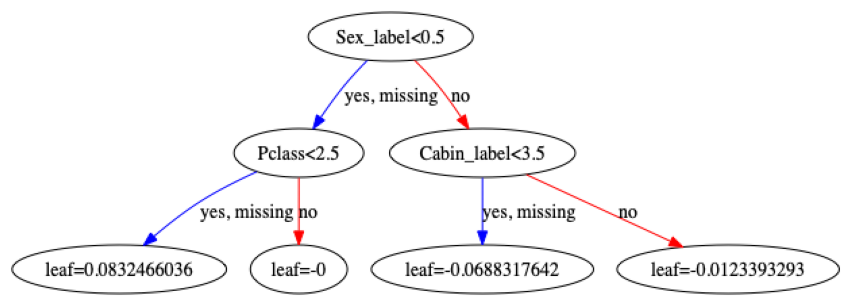

In [20]:
rcParams['figure.figsize'] = 15,10
plot_tree(xgb_model, num_trees=1)

In [165]:
xgb_model.feature_names

['Pclass', 'Age', 'Fare', 'Sex_label', 'Cabin_label', 'Embarked_label']

In [166]:
[(node.id, node.feature()) for node in xgb_shadow.leaves], [(node.id, node.feature()) for node in xgb_shadow.internal]

([(3, -2), (7, -2), (8, -2), (9, -2), (10, -2), (11, -2), (12, -2)],
 [(4, 2), (1, 0), (5, 1), (6, 1), (2, 4), (0, 3)])

## node to samples

In [168]:
xgb_shadow.get_node_samples()

defaultdict(list,
            {10: [0, 4, 5, 12, 13, 17],
             5: [0, 4, 5, 7, 12, 13, 16, 17],
             2: [0, 4, 5, 6, 7, 12, 13, 16, 17],
             0: [0,
              1,
              2,
              3,
              4,
              5,
              6,
              7,
              8,
              9,
              10,
              11,
              12,
              13,
              14,
              15,
              16,
              17,
              18,
              19],
             3: [1, 3, 9, 11, 15],
             1: [1, 2, 3, 8, 9, 10, 11, 14, 15, 18, 19],
             7: [2, 8, 10, 14, 18, 19],
             4: [2, 8, 10, 14, 18, 19],
             12: [6],
             6: [6],
             9: [7, 16]})

In [171]:
xgb_shadow.get_node_samples()[0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

## Node nsample

In [173]:
[(node.id, node.nsamples()) for node in xgb_shadow.leaves], [(node.id, node.nsamples()) for node in xgb_shadow.internal]


([(3, 5), (7, 6), (8, 0), (9, 2), (10, 6), (11, 0), (12, 1)],
 [(4, 6), (1, 11), (5, 8), (6, 1), (2, 9), (0, 20)])

## n_sample_classes

In [201]:
[node.n_sample_classes() for node in xgb_shadow.leaves]

[[0, 5], [2, 4], [0, 0], [2, 0], [5, 1], [0, 0], [1, 0]]

## is classifier

# Visualisations classifier

## viz_leaf_samples

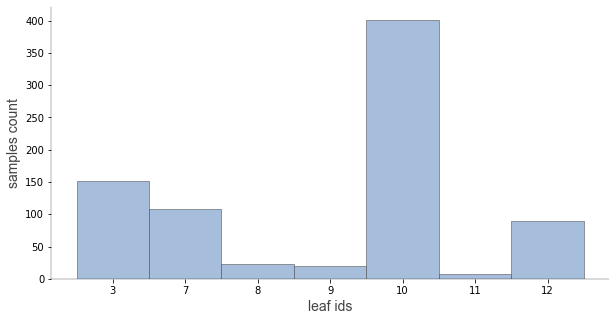

In [36]:
treeviz.viz_leaf_samples(xgb_model, d[features], d[target], features, target, class_names=[0, 1], tree_index=1)

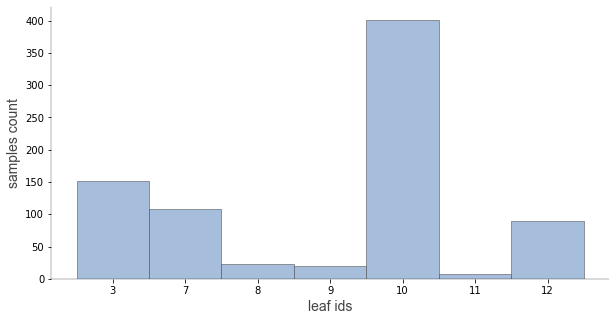

In [37]:
treeviz.viz_leaf_samples(xgb_shadow)

## ctreeviz_leaf_samples

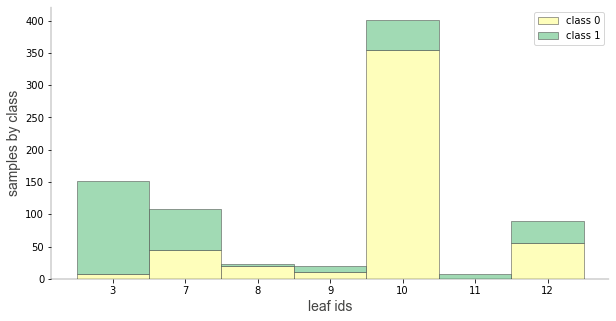

In [38]:
treeviz.ctreeviz_leaf_samples(xgb_model, d[features], d[target], features, target, class_names=[0, 1], tree_index=1  )

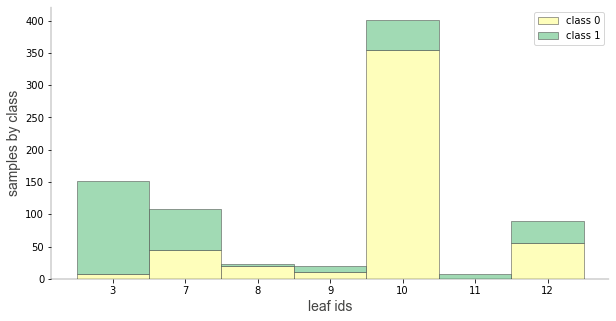

In [39]:
treeviz.ctreeviz_leaf_samples(xgb_shadow)

## dtreeviz

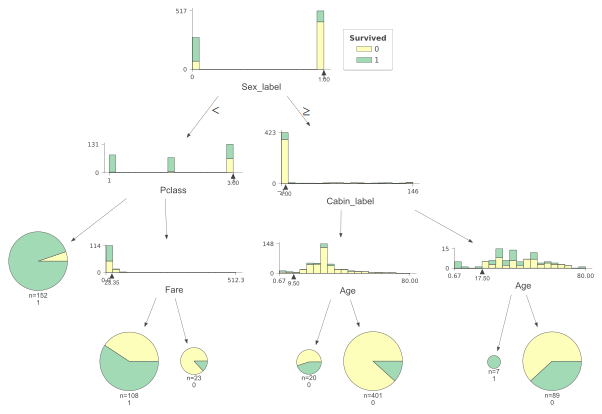

In [40]:
treeviz.dtreeviz(xgb_model, d[features], d[target], features, target, class_names=[0, 1], tree_index=1)

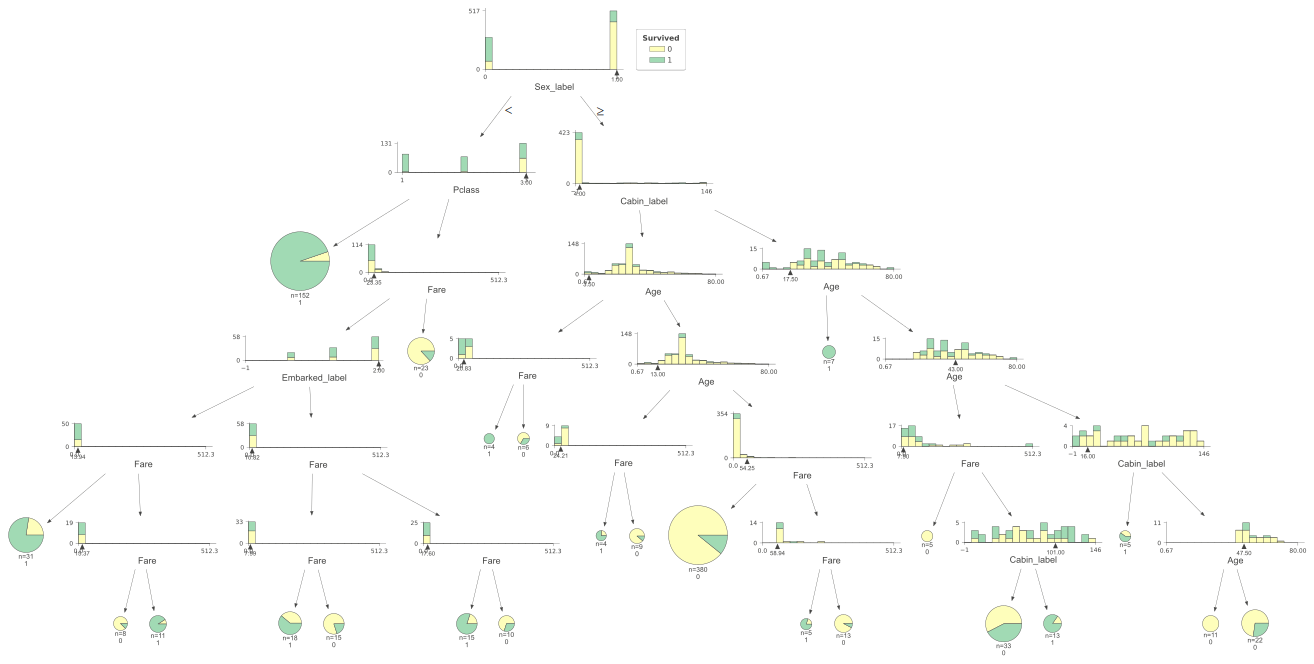

In [54]:
treeviz.dtreeviz(xgb_shadow, )

## describe_node_sample

In [42]:
d[features]

,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label
0,3,22.000000,7.2500,1,-1,2
1,1,38.000000,71.2833,0,81,0
2,3,26.000000,7.9250,0,-1,2
3,1,35.000000,53.1000,0,55,2
4,3,35.000000,8.0500,1,-1,2
5,3,29.699118,8.4583,1,-1,1
6,1,54.000000,51.8625,1,129,2
7,3,2.000000,21.0750,1,-1,2
8,3,27.000000,11.1333,0,-1,2
9,2,14.000000,30.0708,0,-1,0


In [43]:
treeviz.describe_node_sample(xgb_model, 1, d[features], features, tree_index=1)

,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label
count,283.000000,283.000000,283.000000,283.0,283.000000,283.000000
mean,2.173145,27.953908,45.067698,0.0,23.151943,1.420495
std,0.851607,12.760286,59.964198,0.0,42.797414,0.844173
min,1.000000,0.750000,6.750000,0.0,-1.000000,-1.000000
25%,1.000000,21.000000,11.133300,0.0,-1.000000,1.000000
50%,2.000000,29.699118,22.358300,0.0,-1.000000,2.000000
75%,3.000000,34.500000,55.450000,0.0,35.000000,2.000000
max,3.000000,63.000000,512.329200,0.0,145.000000,2.000000


In [44]:
treeviz.describe_node_sample(xgb_shadow, 1)

,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label
count,283.000000,283.000000,283.000000,283.0,283.000000,283.000000
mean,2.173145,27.953908,45.067698,0.0,23.151943,1.420495
std,0.851607,12.760286,59.964198,0.0,42.797414,0.844173
min,1.000000,0.750000,6.750000,0.0,-1.000000,-1.000000
25%,1.000000,21.000000,11.133300,0.0,-1.000000,1.000000
50%,2.000000,29.699118,22.358300,0.0,-1.000000,2.000000
75%,3.000000,34.500000,55.450000,0.0,35.000000,2.000000
max,3.000000,63.000000,512.329200,0.0,145.000000,2.000000


## explain_prediction_path

In [74]:
dataset[features].iloc[5]

Pclass             3.000000
Age               29.699118
Fare               8.458300
Sex_label          1.000000
Cabin_label       -1.000000
Embarked_label     1.000000
Name: 5, dtype: float64

In [81]:
treeviz.explain_prediction_path(xgb_shadow, dataset[features].iloc[5], explanation_type="plain_english")

13.0 <= Age
Fare < 54.25
Sex_label < 1.0
Cabin_label < 4.0


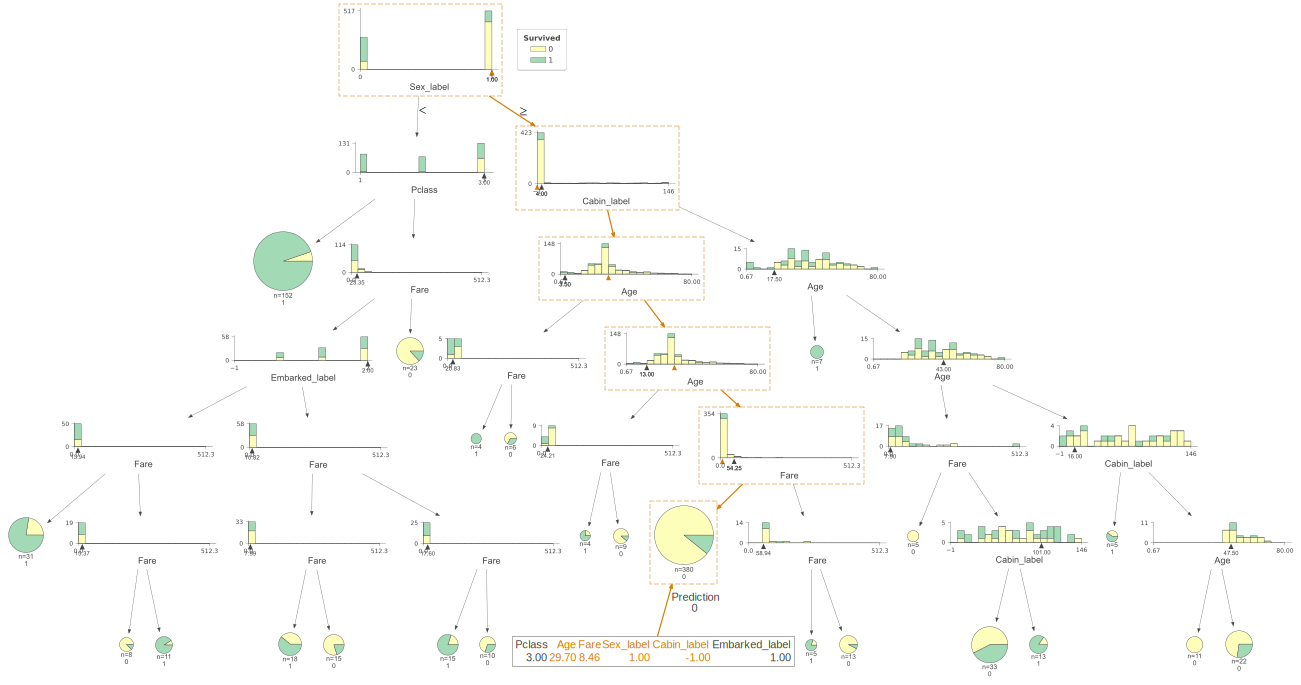

In [79]:
treeviz.dtreeviz(xgb_model, d[features], d[target], features, target, class_names=[0, 1], tree_index=1, show_just_path=False, X=dataset[features].iloc[5] )

In [10]:
%connect_info

{
  "shell_port": 57519,
  "iopub_port": 57520,
  "stdin_port": 57521,
  "control_port": 57523,
  "hb_port": 57522,
  "ip": "127.0.0.1",
  "key": "8ae1d5dc-d42c3c152ff94d3388261e4f",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-dcdd7267-4868-4d6e-81c5-46ae0cc10cdc.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


# Visualisations regressor